# Introduction to Time Series Analysis with Transformers

The transformative landscape of deep learning has witnessed monumental strides in the recent past, particularly in the domain of Natural Language Processing (NLP). Central to this revolution has been the advent of transformer architectures, which, with their attention mechanisms, have pushed the boundaries of what's achievable in tasks like machine translation, sentiment analysis, and language modeling. However, while transformers initially rose to prominence primarily within the realm of NLP, their applicability isn't restricted to just textual data. A growing wave of interest has emerged around leveraging these models for time-series predictions—a challenge that, though numerically distinct, bears conceptual resemblance to understanding sequences in language.

In time-series prediction, the objective often centers around forecasting future values based on historical data. This could involve predicting stock prices, weather patterns, or even the consumption of electricity in a region. At its core, this is a sequence-to-sequence task, where the past values form an input sequence and the future values to be predicted form an output sequence. Now, consider the similarities with machine translation in NLP, where an input sequence (sentence) in one language is translated into an output sequence in another language. Both scenarios require the model to recognize patterns, interdependencies, and context across sequences.

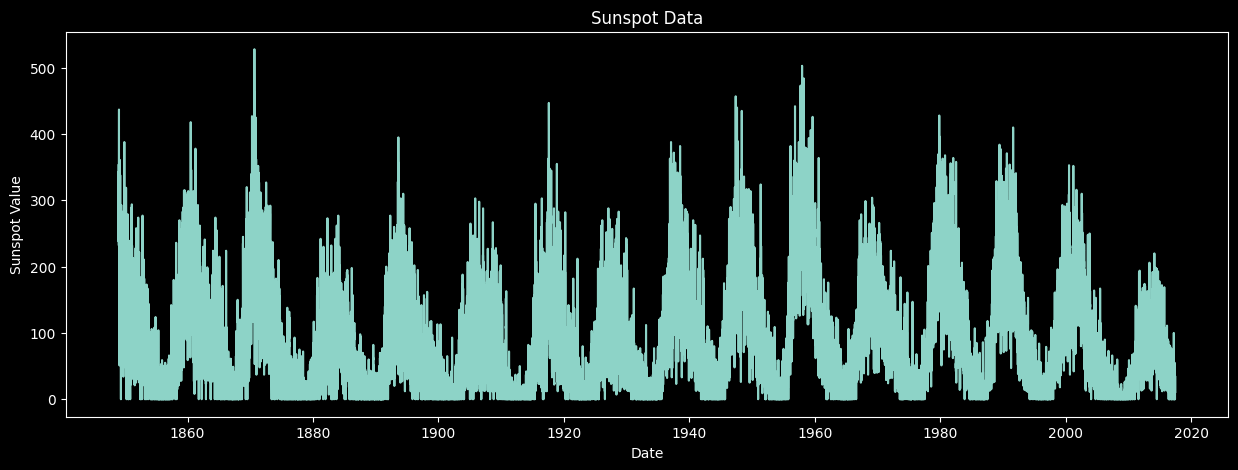

## Dataset
https://www.sidc.be/SILSO/datafiles#total
http://www.sidc.be/silso/INFO/sndtotcsv.php

# References:

[Transformer-Based Time Series with PyTorch](https://www.youtube.com/watch?v=NGzQpphf_Vc&t=1s&ab_channel=JeffHeaton)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

plt.style.use('dark_background')

# Preprocess Data

In [2]:
# Function to encode the month as an angle on the unit circle
def encode_month_as_angle(month):
    n_months = 12 # 12 months in a year
    angle = (month - 1) * (2*np.pi/n_months)
    x = np.cos(angle)
    y = np.sin(angle)
    return x, y

In [3]:
# Function to calculate linear trend
def calculate_trend(x):
    x = x.interpolate()  # Interpolate missing values
    n = x.shape[0]
    A = np.vstack([np.arange(n), np.ones(n)]).T
    m, c = np.linalg.lstsq(A, x, rcond=None)[0]
    trend = m * np.arange(n) + c
    return pd.Series(trend, index=x.index)

In [4]:
data_path = "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv"

window_size = 4
lookahead = 1

In [5]:
# Define column names
col_names = [
    'year', 
    'month', 
    'day', 
    'dec_year', 
    'sunspot_value',
    'sunspot_number_error', 
    'observation', # 1=valid, 0=invalid
    'unused1',
]

# Load the data
df_raw = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', 
    header=None, 
    names=col_names,
    na_values=['-1'], 
    index_col=False,
    )

In [6]:
# Find the first index where observations are consistently valid
# There's a lot of missing data between 1818 and 1848 and we want to skip this
start_id = df_raw[df_raw['observation'] == 0].index[-1] + 1
df_raw = df_raw.iloc[start_id:]

# Set the index to a datetime object
df_raw['date'] = pd.to_datetime(df_raw[['year', 'month', 'day']])
df_raw.index = df_raw['date']

# Apply the function to encode year and month
df_raw['year'] = df_raw['date'].dt.year.astype(np.float32)
df_raw['month_x'], df_raw['month_y'] = zip(*df_raw['date'].dt.month.apply(encode_month_as_angle))

# Convert the sunspot_value to a float
df_raw['sunspot_value'] = df_raw['sunspot_value'].astype(float)

# Calculate the linear trend
df_raw['trend'] = calculate_trend(df_raw['sunspot_value'])

# Calculate the seasonality
df_raw['detrended'] = df_raw['sunspot_value'] - df_raw['trend']

# Calculate rolling mean and rolling standard deviation
df_raw['rolling_mean'] = df_raw['detrended'].rolling(window=window_size, center=False).mean()
df_raw['rolling_std'] = df_raw['detrended'].rolling(window=window_size, center=False).std()
df_raw['detrended_positive'] = (df_raw['detrended'] > 0).astype(int)

# filter the columns we want to use
columns = ['sunspot_value', 'month_x', 'month_y', 'trend', 'detrended', 'rolling_mean', 'rolling_std', 'detrended_positive']
df_raw = df_raw[columns]

In [7]:
df_raw.head()

,sunspot_value,month_x,month_y,trend,detrended,rolling_mean,rolling_std,detrended_positive
date,,,,,,,,
1848-12-23,353.0,0.866025,-0.5,77.814317,275.185683,NaN,NaN,1
1848-12-24,240.0,0.866025,-0.5,77.814569,162.185431,NaN,NaN,1
1848-12-25,275.0,0.866025,-0.5,77.814822,197.185178,NaN,NaN,1
1848-12-26,352.0,0.866025,-0.5,77.815074,274.184926,227.185305,56.680367,1
1848-12-27,268.0,0.866025,-0.5,77.815326,190.184674,205.935052,47.946878,1


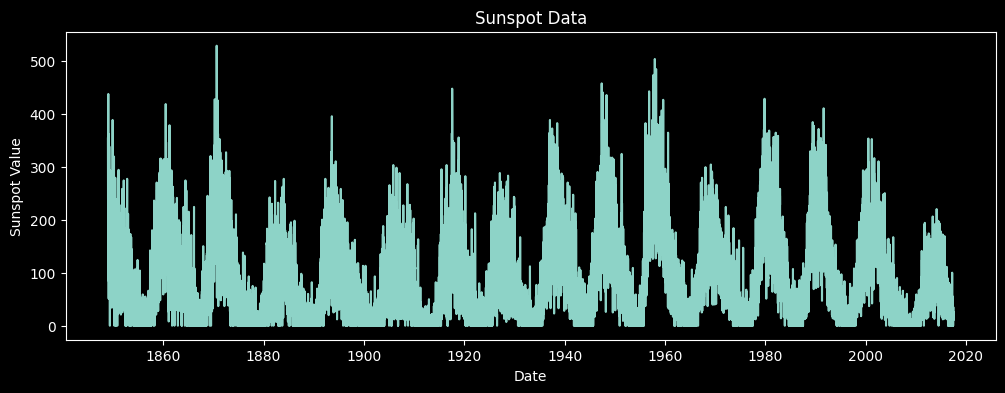

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(df_raw.index, df_raw["sunspot_value"], label="sunspot value")
plt.title("Sunspot Data")
plt.xlabel("Date")
plt.ylabel("Sunspot Value")
plt.grid(False)
plt.show()

# Create Training, Validation and Test Sets

In [9]:
# Copy the dataframe
timeseries = df_raw.copy()

In [10]:
# Define the split sizes
train_size = (4/6)
val_size = (1/6)

# Calculate the indices for the splits
n_data = len(timeseries)
train_index_end = int(n_data * train_size)
val_index_end = train_index_end + int(n_data * val_size)

# Split the data
train_df = timeseries.iloc[:train_index_end].dropna()
val_df = timeseries.iloc[train_index_end:val_index_end].dropna()
test_df = timeseries.iloc[val_index_end:].dropna()

In [11]:
train_df

,sunspot_value,month_x,month_y,trend,detrended,rolling_mean,rolling_std,detrended_positive
date,,,,,,,,
1848-12-26,352.0,8.660254e-01,-0.5,77.815074,274.184926,227.185305,56.680367,1
1848-12-27,268.0,8.660254e-01,-0.5,77.815326,190.184674,205.935052,47.946878,1
1848-12-28,285.0,8.660254e-01,-0.5,77.815579,207.184421,217.184800,38.635103,1
1848-12-29,343.0,8.660254e-01,-0.5,77.815831,265.184169,234.184547,41.737284,1
1848-12-30,340.0,8.660254e-01,-0.5,77.816084,262.183916,231.184295,38.183464,1
...,...,...,...,...,...,...,...,...
1961-04-24,51.0,6.123234e-17,1.0,88.172415,-37.172415,-30.672037,11.090810,0
1961-04-25,68.0,6.123234e-17,1.0,88.172668,-20.172668,-32.172289,8.123821,0
1961-04-26,85.0,6.123234e-17,1.0,88.172920,-3.172920,-24.422541,16.275953,0


In [12]:
def create_timeseries_dataset(df:pd.DataFrame, target:str, lookback:int=5, lookahead:int=1):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    x, y = [], []
    n_samples = df.shape[0]
    for i in range(n_samples-lookback):
        # it says lookback, but we're shifting index
        x_sample = df.iloc[i:i+lookback]
        y_sample = df[target].iloc[i+lookback:i+lookback+lookahead]
        x.append(x_sample)
        y.append(y_sample)
    x, y = np.array(x), np.array(y)
    return x, y

In [13]:
lookback = window_size

x_train, y_train = create_timeseries_dataset(df=train_df, target='sunspot_value', lookback=lookback, lookahead=lookahead)
x_val, y_val = create_timeseries_dataset(val_df, target='sunspot_value', lookback=lookback, lookahead=lookahead)
x_test, y_test = create_timeseries_dataset(test_df, target='sunspot_value', lookback=lookback, lookahead=lookahead)

In [14]:
x_scaler = StandardScaler()

# scale the data
x_train_scaled = x_scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)

x_val_scaled = x_scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

x_test_scaled = x_scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

# Transform to PyTorch tensors
x_train_scaled = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_val_scaled = torch.tensor(x_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

x_test_scaled = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [15]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(41027, 4, 8) torch.Size([41027, 1])
(10254, 4, 8) torch.Size([10254, 1])
(10255, 4, 8) torch.Size([10255, 1])


In [16]:
print(x_train[0], y_train[0])

[[352.           0.8660254   -0.5         77.81507397 274.18492603
  227.18530472  56.68036674   1.        ]
 [268.           0.8660254   -0.5         77.81532643 190.18467357
  205.93505226  47.94687809   1.        ]
 [285.           0.8660254   -0.5         77.81557888 207.18442112
  217.1847998   38.63510335   1.        ]
 [343.           0.8660254   -0.5         77.81583134 265.18416866
  234.18454734  41.73728359   1.        ]] tensor([340.])


In [17]:
train_dataset = TensorDataset(x_train_scaled, y_train)
val_dataset = TensorDataset(x_val_scaled, y_val)
test_dataset = TensorDataset(x_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [18]:
batch_x, batch_y = next(iter(train_loader))
print(f"Number of batches in train_loader: {len(train_loader)}")
print("Dimensions: (batch, sequence length, features)")
print(f"Shape of x_train: {batch_x.shape}")
print(f"Shape of y_train: {batch_y.shape}")

Number of batches in train_loader: 321
Dimensions: (batch, sequence length, features)
Shape of x_train: torch.Size([128, 4, 8])
Shape of y_train: torch.Size([128, 1])


# Model Utilities

In [19]:
def train_regression(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []

    for x_train, y_train in data_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total

def validate_regression(model, data_loader, criterion, device):
    model.to(device).eval()
    batch_loss = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            batch_loss.append(loss.item())
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total

def evaluate_regression(model, data_loader, device):
    model.to(device).eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            predictions.append(y_hat)
            actuals.append(y)

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    actuals = torch.cat(actuals, dim=0).cpu().numpy()

    return predictions, actuals

def inference_regression(model:nn.Module, x:torch.tensor, device:torch.device):
    model.eval().to(device)
    with torch.no_grad():
        x = x.to(device)
        y_hat = model(x)
    return y_hat.cpu()

# Model Setup
The following code constructs the actual transformer-based model for time series prediction. The model is constructed to accept the following parameters.

* input_dim: The dimension of the input data, in this case we use only one input, the number of sunspots.
* d_model: The number of features in the transformer model's internal representations (also the size of embeddings). This controls how much a model can remember and process.
* nhead: The number of attention heads in the multi-head self-attention mechanism.
* num_layers: The number of transformer encoder layers. dropout: The dropout probability.

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int = 512, dropout: float = 0.1, max_seq_len: int = 5000):
        """Initialize the PositionalEncoding module."""
        super().__init__()
        self.embed_dim = d_model
        self.max_seq_len = max_seq_len
        self.dropout = nn.Dropout(dropout)
        # Precompute the positional encoding matrix
        positional_encoding = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        positional_encoding[:, 0::2] = torch.sin(position * division_term)
        positional_encoding[:, 1::2] = torch.cos(position * division_term)
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding) # Register the positional encoding as buffer to not include it in the model's state_dict

    def forward(self, x):
        x += self.positional_encoding[:x.size(0), :]
        x = self.dropout(x)
        return x

The Transformer architecture in PyTorch is governed by crucial configuration choices, among which d_model, nhead, and num_layers hold significant weight. The d_model denotes the dimensionality of the input embeddings and affects the model's capacity to learn intricate representations. While a more substantial d_model can bolster the richness of the model's understanding, it also amplifies the computational demand and can pose overfitting risks if not carefully chosen. Parallelly, the model's gradient flow and initialization are impacted by this choice, though the Transformer's normalization layers often moderate potential issues.

On the other hand, nhead reflects the count of heads in the multi-head attention mechanism. A higher number of heads grants the model the prowess to simultaneously focus on diverse segments of the input, enabling the capture of varied contextual nuances. However, there's a trade-off. Beyond a specific threshold, the computational overhead might outweigh the marginal performance gains. This parallel processing, provided by multiple attention heads, tends to offer more stable and varied gradient information, positively influencing the training dynamics.

Lastly, the num_layers parameter dictates the depth of the Transformer, determining the number of stacked encoder or decoder layers. A deeper model, as a result of increased layers, can discern more complex and hierarchical relationships in data. Still, there's a caveat: after a certain depth, potential performance enhancements may plateau, and the risk of overfitting might escalate. Training deeper models also comes with its set of challenges. Although residual connections and normalization in Transformers alleviate some concerns, a high layer count might necessitate techniques like gradient clipping or learning rate adjustments for stable training.

In essence, these parameters intricately balance model capacity, computational efficiency, and generalization capability. Their optimal settings often emerge from task-specific experimentation, the nature of the data, and available computational prowess.

In [21]:
class Transformer(nn.Module):
    def __init__(self, input_dim=8, d_model=64, nhead=4, num_layers=2, dropout=0.2, max_seq_len=10):
        super().__init__()

        self.input_embeddings = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(
            d_model = d_model, 
            dropout = dropout,
            max_seq_len=max_seq_len)
        encoder_block = nn.TransformerEncoderLayer(
            d_model = d_model, 
            nhead = nhead,
            dim_feedforward = 2048,
            dropout = dropout,
            batch_first=True,
            )
        self.encoder = nn.TransformerEncoder(encoder_block, num_layers)
        self.projection_head = nn.Linear(d_model, 1)

    def forward(self, x):
        # (batch_size, seq_len, features) -> (batch_size, seq_len, d_model)
        x = self.input_embeddings(x)
        # (batch_size, seq_len, d_model) -> (batch_size, seq_len, d_model)
        x = self.pos_encoder(x)
        # Calculate last_hidden_state
        # (batch_size, seq_len, d_model) -> (batch_size, seq_len, d_model)
        x = self.encoder(x)
        # (batch_size, seq_len, d_model) -> # (batch_size, 1, d_model) -> (batch_size, 1)
        x = self.projection_head(x[:, -1, :])
        return x

# Training Loop

In [22]:
# hyperparameters
n_features = x_train.shape[-1]
hidden_size = 64
output_size = 1
num_layers = 2

# training parameters
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate model, loss function and optimizer
model = Transformer(input_dim=n_features, d_model=hidden_size, nhead=output_size, num_layers=num_layers, max_seq_len=lookback)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [23]:
# lists to store loss and accuracy
train_loss = []
val_loss = []
print_every = 10

for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    epoch_train_loss = train_regression(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_train_loss)
    epoch_val_loss = validate_regression(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)
    scheduler.step()
    if epoch % print_every == 0:
        print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} - Val loss: {epoch_val_loss:.4f}')

Training Progress:   1%|          | 1/100 [00:01<02:26,  1.48s/it]

[1/100] Train loss: 10238.5033 - Val loss: 7731.7981


Training Progress: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


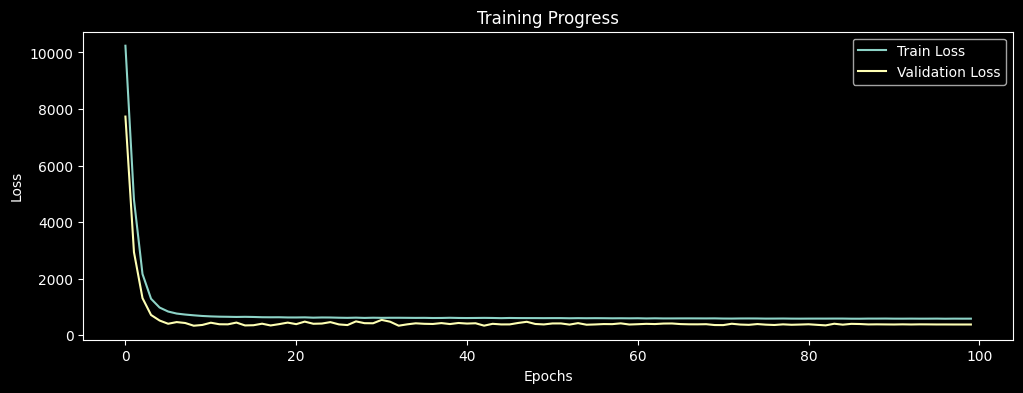

In [24]:
# plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

## Model Evaluation

In [25]:
# get predictions, without shuffling
y_train_hat = inference_regression(model, x_train_scaled, device)
y_val_hat = inference_regression(model, x_val_scaled, device)
y_test_hat = inference_regression(model, x_test_scaled, device)

In [26]:
y_train.shape, y_train_hat.shape

(torch.Size([41027, 1]), torch.Size([41027, 1]))

# Evaluate Model

In [27]:
mse_train = mean_squared_error(y_train, y_train_hat)
mse_val = mean_squared_error(y_val, y_val_hat)
mse_test = mean_squared_error(y_test, y_test_hat)

print(f"Train MSE: {mse_train:.2f}")
print(f"Val MSE: {mse_val:.2f}")
print(f"Test MSE: {mse_test:.2f}")

Train MSE: 645.81
Val MSE: 369.98
Test MSE: 372.63


# Inference

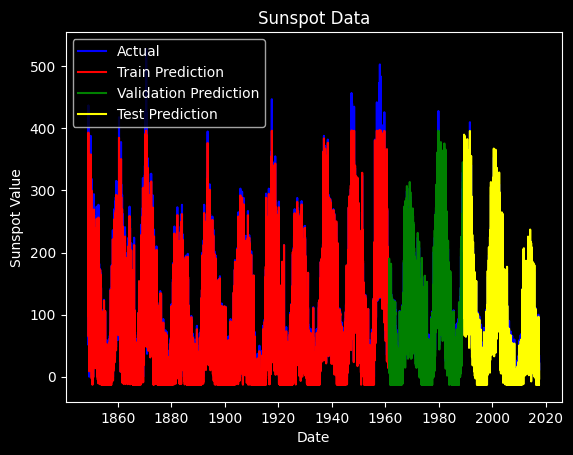

In [28]:
# Plot actual passenger data
plt.plot(timeseries['sunspot_value'], color='blue', label='Actual')

# Calculate indices for plotting
train_start_idx = lookback + window_size - 1
train_end_idx = train_start_idx + len(y_train) - 1
val_start_idx = train_end_idx + window_size + 1
val_end_idx = val_start_idx + len(y_val) - 1
test_start_idx = len(timeseries) - len(y_test_hat)

# Plot predicted train data
plt.plot(timeseries.index[train_start_idx:train_end_idx + 1], y_train_hat, color='red', label='Train Prediction')

# Plot predicted validation data
plt.plot(timeseries.index[val_start_idx:val_end_idx + 1], y_val_hat, color='green', label='Validation Prediction')

# Plot predicted test data
plt.plot(timeseries.index[test_start_idx:], y_test_hat, color='yellow', label='Test Prediction')

# Add titles and labels
plt.title('Sunspot Data')
plt.xlabel('Date')
plt.ylabel('Sunspot Value')

# Show legend
plt.legend()

# Display the plot
plt.show()